<a href="https://www.kaggle.com/code/embarkiomar/arabert?scriptVersionId=169646670" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:

arabic = pd.read_excel('/kaggle/input/arabic/dataset_rannotation.xlsx')
data = arabic[['new_comments', 'omar annotation']]

In [3]:
data

,new_comments,omar annotation
0,حرب اللهم انتصر مرض,positive
1,حرب ابطال فعل ربی شفاء مرض,positive
2,اسال اللهم شفاء اختی حرب استمد قوة صبر,neutral
3,احسن,neutral
4,حرب شاء اللهم انتصر انسان يحس ظن رب عباد اخر لحظة,positive
...,...,...
2845,مرض حالة حرج حاجة صفايح دم تبرع رجال زمر يقيند...,negative
2846,بارك تحرج لصرخ طفل مصاب سرطان اح كانم اح ناس ج...,negative
2847,طفل صغير ليسير انفال متواجد مستشفى حاس وهر حاج...,negative
2848,نحتاج اربع اشخاص مرض لا لعلباس مقبل عمل جراح م...,negative


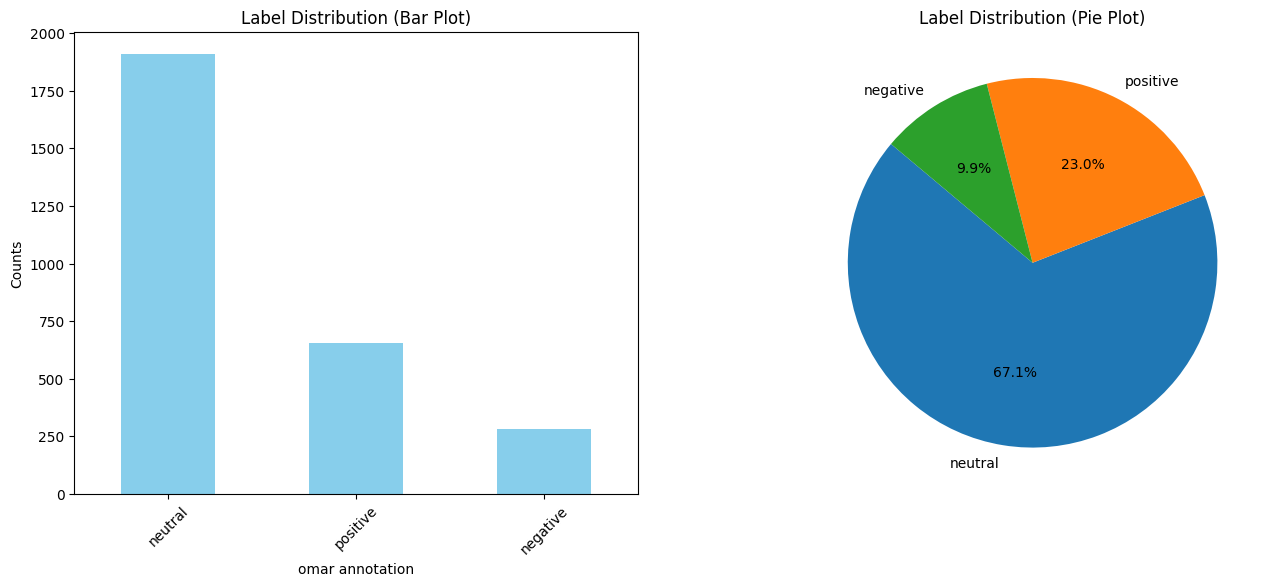

In [4]:
label_counts = data['omar annotation'].value_counts()

# Plot label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
label_counts.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_title('Label Distribution (Bar Plot)')
ax1.set_xlabel('omar annotation')
ax1.set_ylabel('Counts')
ax1.tick_params(axis='x', rotation=45)

# Pie plot
ax2.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
ax2.set_title('Label Distribution (Pie Plot)')

plt.show()

In [5]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import wandb
import os

# Set the WandB API key
os.environ["WANDB_API_KEY"] = "a9167db6baf3583b4a94dec0da044c6619043b38"

# Load the dataset
data = pd.read_excel('/kaggle/input/arabic/dataset_rannotation.xlsx')
data = data[['new_comments', 'omar annotation']]

# Map the labels to numerical values
label_mapping = {'positive': 2, 'negative': 0, 'neutral': 1}
data['label'] = data['omar annotation'].map(label_mapping)

# Drop rows with non-finite values in the 'label' column
data = data.dropna(subset=['label'])

# Convert label column to integer type
data['label'] = data['label'].astype(int)

# Split the dataset into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Load the pre-trained AraBERT model and tokenizer
model_name = 'aubmindlab/bert-base-arabertv02'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # Specify num_labels=3

# Freeze the base layer of the model
for param in model.base_model.parameters():
    param.requires_grad = False

# Tokenize the data
train_encodings = tokenizer(list(train_data['new_comments'].values), truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(list(val_data['new_comments'].values), truncation=True, padding=True, return_tensors='pt')

# Define the dataset class
class ArabicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {'input_ids': self.encodings['input_ids'][idx],
                'attention_mask': self.encodings['attention_mask'][idx]}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ArabicDataset(train_encodings, train_data['label'].values)
val_dataset = ArabicDataset(val_encodings, val_data['label'].values)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    disable_tqdm=False,  # Enable tqdm progress bar
)

# Create the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Fine-tune the model
trainer.train()

# Evaluate the model
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = val_dataset[:]['labels']
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


2024-04-01 00:43:33.355375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 00:43:33.355498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 00:43:33.649985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Currently logged in as: oembarki7 (xycar). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
0,0.948400,0.883169
1,0.831100,0.838927
2,0.807800,0.809480
4,0.801200,0.777920
5,0.815800,0.769613
6,0.821100,0.763740
8,0.773400,0.758120
9,0.748400,0.757513


Accuracy: 0.6701754385964912
Precision: 0.34506680369989723
Recall: 0.33866182836771075
F1 Score: 0.28931396859133307


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Calculate probabilities for each class
probs = predictions.predictions
probs = torch.nn.functional.softmax(torch.tensor(probs), dim=1).numpy()

# Compute ROC metrics
fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Compute PRC metrics
precision, recall, _ = precision_recall_curve(true_labels, probs[:, 1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot PRC curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PRC curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Log ROC and PRC plots to wandb
wandb.log({"ROC Curve": plt})
wandb.log({"PRC Curve": plt})


NameError: name 'roc_curve' is not defined

In [9]:
# Let the user input their comment
user_comment = input("Please enter your comment: ")

# Tokenize the user's comment
new_encodings = tokenizer([user_comment], truncation=True, padding=True)

# Create a new Dataset object for the user's comment
new_dataset = ArabicDataset(new_encodings, labels=[0])  # dummy label

# Use the trained model to make predictions
new_predictions = trainer.predict(new_dataset)

# The predictions are in the form of logits, so we need to take the argmax to get the predicted label
new_predicted_label = np.argmax(new_predictions.predictions, axis=1)[0]

# Map the numerical label back to its original value
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
new_predicted_label = reverse_label_mapping[new_predicted_label]

print(f"The sentiment of your comment is: {new_predicted_label}")


Please enter your comment:  السلام عليكم عمي محتاج بزاف دم وصفائح دموية لي يقدر يتبرع راح يعاون بزاف


The sentiment of your comment is: neutral


In [ ]:
# Save the trained model
model_path = "./model"
trainer.save_model(model_path)

# Save the tokenizer
tokenizer_path = "./tokenizer"
tokenizer.save_pretrained(tokenizer_path)


In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
